# ACSE Module 8 - Practical - Morning Session 5 (Execises):

# Time-Series Data


## What is Time-Series Data?
Any data that varies along the time dimension is called Time-Series data. e.g.:
- Sales of ice cream per day in the Senior Common Room at Imperial College
- Average price of the Apple stock by day
- The closing value of FTSE100 by day
- Average daily temperatures in Australia
- EEG data
- Room occupancy sensor data
- The complete text of 1984 by George Orwell

## What can we do with time-series?
- Forecasting - predict the future!
- Generate text - e.g. autocomplete
- Anomaly detection - e.g. detect a siezure happening/about to happen from EEG data
- Classification - e.g. room occupied/not occupied, sentiment analysis of text

## What makes time-series data special?
- There is a concept of "past" and "future" in time-series data
- In the case of Forecasting, the model must be retrained after essentially every prediction
- Non-stationary probability distribution of data

Although there is a large number of classical time-series methods that work really well, we are going to focus on neural networks in this session. 

The neural networks we have seen so far have no concept of _order_ in inputs. Each time a fresh input is presented, it is treated in isolation by the neural network architectures we have seen so far. In time-series analysis, the _context_ is extremely important, i.e. what came before this?


## Recurrent Neural Networks

Recurrent Neural Networks (RNNs) solve this problem by incorporating loops within them. The loop signifies that information can persist from one set of inputs to another. 

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png" width=100 />

This network accepts input _x<sub>t</sub>_ and provides output _h<sub>t</sub>_ at every step _t_. 


The network can also be seen in the following _unrolled_ visualisation:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width=600 />

#### A few imports and functions before we get started

In [ ]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 573kB 12.9MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import random
import time
import math

import glob
import string
import unicodedata
import re
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

No GPU available! Running on CPU


#### Mounting the google drive for storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Text as time-series data

Textual data can also be seen as a time-series since it varies along a single dimension.

There are two distinct ways of looking at this data:
- Every character can be seen as an individual data point (character-level)
- Every word can be seen as a new data point (word-level)



### Classifying names with a character-level RNN

When working with text data at the character level, the advantage is that the set of possible inputs (all possible characters) is relatively small. We commonly use the [ASCII](https://en.wikipedia.org/wiki/ASCII#:~:text=Originally%20based%20on%20the%20English,to%20Z%2C%20and%20punctuation%20symbols.) Characters which has 52 letters (26 uppercase and 26 lowercase).

However, an obvious disadvantage is the risk of _missing the forest for the trees_, i.e. higher-level patterns might be less obvious when looking at fine-grained data. 

In [ ]:
all_letters = string.ascii_letters

print("alphabet:", all_letters)
print("n_letters:", len(all_letters))

alphabet: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
n_letters: 52


## Data preparation (preprocessing) and some utility functions to get started

In [ ]:
# Download dataset of common last names from different languages
!mkdir data
!cd data && wget https://raw.githubusercontent.com/acse-2019/ACSE-8/master/Implementation/practical_5/morning/data/names.zip && unzip names.zip

--2021-05-10 12:16:28--  https://raw.githubusercontent.com/acse-2019/ACSE-8/master/Implementation/practical_5/morning/data/names.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73484 (72K) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]  71.76K  --.-KB/s    in 0.009s  

2021-05-10 12:16:28 (8.19 MB/s) - ‘names.zip’ saved [73484/73484]

Archive:  names.zip
   creating: names/
  inflating: __MACOSX/._names        
  inflating: names/Czech.txt         
  inflating: __MACOSX/names/._Czech.txt  
  inflating: names/German.txt        
  inflating: __MACOSX/names/._German.txt  
  inflating: names/Arabic.txt        
  inflating: __MACOSX/names/._Arabic.txt  
  inflating: names/Japanese.txt      
  inflating: __MACOSX/names

In [ ]:
all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt']


#### Turning a Unicode string to plain ASCII (from http://stackoverflow.com/a/518232/2809427)

In [ ]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


#### Reading files into a usable data format

In [ ]:
def readLines(filename): 
    """ 
    Read a file and return list with line entries 
    """
    lines = open(filename, encoding="utf8").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

def get_data(filenames):
    """ 
    Read files in filenames, returns dictionary {Language: [list of last names]} and list with all categories
    """
    data, categories = {}, []    
    for filename in all_filenames:
        category = filename.split('/')[-1].split('\\')[-1].split('.')[0]
        categories.append(category)
        data[category] = readLines(filename)
    return data, categories

In [ ]:
data, categories = get_data(all_filenames)
n_categories = len(data)

for category in data:
    print(category, len(data[category]))

print("\nTotal Number of last_names:", sum([len(x) for x in data.values()]))
print("Number of categories:", len(data))
print("\n\n", data['Vietnamese'][:5])

Italian 709
Vietnamese 73
Portuguese 74
English 3668
Chinese 268
Scottish 100
Irish 232
Greek 203
Japanese 991
Russian 9384
Spanish 298
Korean 94
French 277
German 724
Czech 519
Dutch 297
Arabic 2000
Polish 139

Total Number of last_names: 20050
Number of categories: 18


 ['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


## Exercise 1: Turning letters and words into tensors

We have loaded the names from the dataset into memory but our neural networks can only deal with tensors so we need a tensor representation for a name. 

To represent each letter numerically, we could simply use its position in the alphabet, e.g. 1 for a, but this would imply an ordering between the letters - that in some way b > a. We don't want our model to learn such an ordering so we want a _non-ordinal_ representation. A common one is _one-hot encoding_. 

### One-hot encoding

One-hot encoding generates vectors that are the size of the number of all possible outcomes, and contain zeros everywhere except one location, which has a 1. For example, to represent _Gender_, we could use 1 to represent _Male_ and 2 to represent _Female_ , but this would imply that _Female_ > _Male_ . So instead we use the vector [0, 1] to represent _Male_ and the vector [1, 0] to represent _Female_. 

So, let's perform the following tasks:

1. Write a function to convert a letter to a one-hot tensor
2. Write a function to convert a word into an array of one-hot letter vectors of shape <word_length x 1 x alphabet_length>.


In [ ]:
def letter_to_tensor(letter, alphabet=string.ascii_letters):
    """ 
    Turn a letter into a one-hot tensor of shape <1 x n_letters>
    """
    # initialize a torch tensor of zeros of appropriate length
    # find the location of the letter in *all_letters*
    # set the appropriate location to 1 here
    return tensor

# hot_encoded_d = letter_to_tensor("d", string.ascii_letters)
# print(hot_encoded_d, hot_encoded_d.shape)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) torch.Size([1, 52])


In [ ]:
def word_to_tensor(word, alphabet=string.ascii_letters):
    """
    Turn a line into of shape <line_length x 1 x n_letters> of one-hot letter vectors
    """
    # define tensor shape <line_length x 1 x n_letters>
    #loop through each character and assign index value in tensor as 1
    return tensor

# hot_encoded_Dubrule = word_to_tensor("Dubrule", alphabet=string.ascii_letters)
# print(hot_encoded_Dubrule, hot_encoded_Dubrule.shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

#### Let's also write a function to turn a tensor to words

In [ ]:
def tensor_to_word(tensor, alphabet=string.ascii_letters):
    """
    One-hot encoded word in torch.tensor format of shape [len_word, len_alphabet] 
    """
    # check tensor has columns = len(alphabet)
    # initialise an empty string called word
    # loop through the rows of hte tensor
    # return index of the largest entry in the row
    # add the entry at index in alphabet to word
                        
    return word

# print(tensor_to_word(hot_encoded_Dubrule))

Dubrule




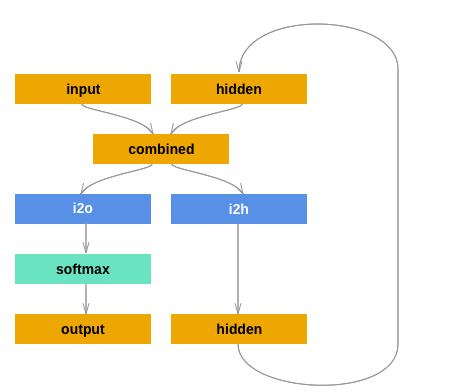

## Exercise 2: Implement a simple RNN for text classification
![](images/RNN-network.png) 

This RNN has (from [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)) just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output. The network should take as input one letter at a time and be able to recycle hidden states for consecutive letters.

Before continuing, think about whether we want to do the classification at every step here or whether we are only interested in the output at the end. Complete the code in the following cell to implement the above network.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):  
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, input, hidden):

        # combine the input and the hidden into a single tensor
        # do the Input->Hidden Transform
        # do the Input->Output Transform
        # softmax on Output        

    def init_hidden(self, batch_size=1):
        return torch.zeros((batch_size,self.hidden_size), requires_grad=True)

Now let's test the inputs and outputs of this module we created.

Remember that the size of the input is <1 x n_letters>. What does this mean for our model?

In [ ]:
n_letters = len(string.ascii_letters)  # input will read [1 x 52], one hot-econded letter at the time
n_hidden = 128                         # hidden vector of size [1, 128], this is a hyperparameter
n_output = n_categories                # we apply a softmax classification at the end to predict the last name origin

rnn = RNN(input_size=n_letters, hidden_size=n_hidden, output_size=n_output)

input_string = "D"
input_vector = letter_to_tensor(input_string) # you can alsouse unsqueeze to add dimension to simulate batch
hidden_vector = rnn.init_hidden(batch_size=input_vector.shape[0])

output, next_hidden_vector = rnn(input_vector, hidden_vector)
print(input_vector.shape, hidden_vector.shape, next_hidden_vector.shape, output.shape)

torch.Size([1, 52]) torch.Size([1, 128]) torch.Size([1, 128]) torch.Size([1, 18])


## Classifying a new (previously unseen) last name into one of the (seen) languages. 

As we have seen, this our network can only take one letter at a time, since we are trating the data at character level.

Since we are interested in the classification (output) at the end, we need to pass all the letters through the network and use the hidden state to operate on the word.

### Let's try the model

In [ ]:
last_name = "Dubrule"
input_vector = word_to_tensor(last_name)[:, :].unsqueeze(0) # use unsqueeze to add dimension to simulate batch
hidden_vector = rnn.init_hidden(batch_size=input_vector.shape[0])
print(input_vector.shape, hidden_vector.shape)

# Loop through each letter
for i in range(input_vector.shape[1]):
    # Hidden vector contains information from previous letters, hence we are only really interested in the output of the final letter
    input_letter = input_vector[:,i]
    output, hidden_vector = rnn(input_letter, hidden_vector) 

print(input_letter.shape)
print(output, output.shape)

torch.Size([1, 7, 52]) torch.Size([1, 128])
torch.Size([1, 52])
tensor([[-2.8297, -2.8268, -2.9329, -2.8236, -2.8164, -2.9754, -2.8308, -2.9867,
         -2.9384, -2.8715, -2.7778, -2.8292, -2.8822, -2.8936, -2.9478, -2.9770,
         -2.9841, -2.9431]], grad_fn=<LogSoftmaxBackward>) torch.Size([1, 18])


In [ ]:
def category_from_output(output, categories):
    """
    Get higher probability category from output. 
    Categories is a list of all categories with order equivalent to that of output
    """
    assert len(categories) == output.shape[1], "len(categories)=%g len(output[0])=%g"%(len(categories), output.shape[1])
    top_value, top_index = output.data.topk(1)
    category_index = top_index[0][0]
    
    return categories[category_index], category_index, torch.exp(top_value) #take exponent because of NLLLoss

pred, pred_idx, pred_val = category_from_output(output, categories)
print("Last Name: %s \t Prediction: %s \t Certainty: %.2f %% \n"%(last_name, pred, pred_val*100))

Last Name: Dubrule 	 Prediction: Spanish 	 Certainty: 6.22 % 



In [ ]:
def rank_from_output(output, categories,top_n_predictions=3):
    """ 
    print(tmp)
    Get the rank of the predictions to give a measure of the certainty of the predictions
    """
    output_list = list((torch.exp(output[0])*100).detach().numpy())
    tmp = list(zip(output_list, categories))
    tmp = sorted(tmp, reverse=True)[:top_n_predictions]
    rank = {}
    for val, cat in tmp:
        print(' %s: \t %.2f%%' % (cat, val))
        rank[cat] = val

rank_from_output(output, categories)

 Spanish: 	 6.22%
 Chinese: 	 5.98%
 English: 	 5.94%


## Exercise 3: The train and evaluate functions

To train the RNN, we will implement _true_ Stochastic Gradient Descent, i.e. one example at a time. 

Write a train function that performs the following tasks:
- Reset gradients
- Create a zeroed initial hidden state
- Read each letter in and
- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

#### Another utility function to measure elapsed time

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### Training and evaluation function for a batch of words

In [ ]:
def train(model, optimizer, criterion, word_tensor, category_tensor):
    # set model to train mode
    # clear optimizer
    # re initialise hidden state with zeros every new name
    
    # Loop through each letter
    # Keep hidden state for next letter        
    
    # compute average loss for batch
    # compute the gradients
    # update the weights

    return output, loss


def evaluate(model, word_tensor):
    model.eval()
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size=word_tensor.shape[0]).to(device)
        for i in range(word_tensor.shape[1]):                   
            output, hidden = rnn(word_tensor[:, i, :] , hidden)
    return output

#### A custom dataset we can loop through.
You can learn more about datasets, dataloaders and creating custom datasets in pytorch from [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
class LastNameTensorDataset(TensorDataset):
    def __init__(self, data_dict, alphabet=string.ascii_letters, pad_to_max=False):
        """
        Args:
            data_dict (dictionary): A dictionary containing all last names and their origin
            alphabet (string, optional): dictionary used to convert last names into hot-encoded vectors
        """
        self.alphabet=alphabet
        self.targets_list = list(data_dict.keys())
        self.data, self.targets = [], []
        self.pad_to_max = pad_to_max
        self.max_len = 0
        for category in data_dict:       #Find length of largest name in the data
            for last_name in data_dict[category]:
                self.targets.append(category)
                self.data.append(last_name)
                
                last_name_len = len(last_name)
                if last_name_len > self.max_len:
                    self.max_len = last_name_len 
        
    def word_to_tensor(self, word, pad_to_max=False):
        if pad_to_max:
            tensor = torch.zeros((self.max_len, len(self.alphabet)))
        else:
            tensor = torch.zeros((len(word), len(self.alphabet)))
            
        for i, letter in enumerate(word):
            letter_index = self.alphabet.find(letter)
            tensor[i][letter_index] = 1
        return tensor
    
    def target_to_tensor(self, target_string):
        return torch.tensor([self.targets_list.index(target_string)], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns hot encoded vector of last name and tensor equivalent of category label
        """
        sample, label = self.data[idx], self.targets[idx]
        sample_vector = self.word_to_tensor(sample, self.pad_to_max)
        label_vector = self.target_to_tensor(label)
        return sample_vector, label_vector

#### Hyperparameters & Model Initilalisation

In [ ]:
device = "cpu" # GPU is slower because computation is not actually parallelised
epochs = 25
alphabet = string.ascii_letters

n_letters = len(alphabet)              # model input will read [1 x 52], one hot-econded letter at the time
n_hidden = 128                         # this is a hyperparameter
n_output = n_categories                # this is the same as len(data)

rnn = RNN(input_size=n_letters, hidden_size=n_hidden, output_size=n_output).to(device)

criterion = nn.NLLLoss()
lr = 5e-3
momentum = 0.5
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, momentum=momentum)
batch_size=1

# Create datasets and dataloaders
pad_to_max = True if batch_size > 1 else False  # if batch size > 1, input vectors need to be of the same size, hence padding. How might this affect training??
dataset = LastNameTensorDataset(data, alphabet, pad_to_max=pad_to_max)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)

[Why](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/other/pytorch-lossfunc-cheatsheet.md) NLLLoss? 

#### The training loop

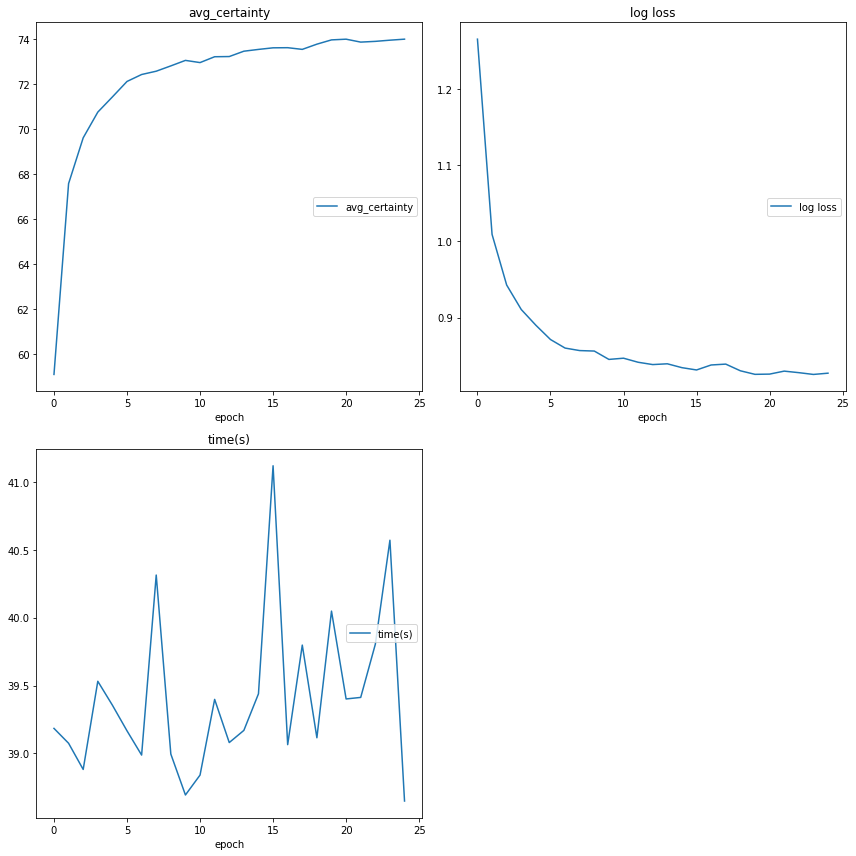

avg_certainty
	avg_certainty    	 (min:   59.091, max:   73.989, cur:   73.989)
log loss
	log loss         	 (min:    0.825, max:    1.265, cur:    0.827)
time(s)
	time(s)          	 (min:   38.650, max:   41.118, cur:   38.650)


In [ ]:
# Keep track of losses for plotting
all_losses = []
n_total_names = sum([len(x) for x in data.values()])
start = time.time()
print_every = 1024

# Train model
liveloss = PlotLosses()
for epoch in range(epochs):
    epoch_start = time.time()
    epoch_loss, epoch_certainty = 0, 0
    
    for i, (sample_tensor, target_tensor) in enumerate(dataloader): # for each batch
        sample_tensor, target_tensor = sample_tensor.to(device), target_tensor.to(device) # send batch to device
        
        output, loss = train(rnn, optimizer, criterion, sample_tensor, target_tensor) # train batch, report output and average loss
        epoch_loss += loss.item() * dataloader.batch_size
        
        for j in range(output.shape[0]):
            pred, pred_idx, pred_val = category_from_output(output[j].unsqueeze(0), dataset.targets_list)
            epoch_certainty += pred_val.item()  # note we're not optimizing for certainty, this is just a simple performance measuring tool

        # Print iter number, loss, name and guess
        n_processed_names = (epoch + 1) * i * dataloader.batch_size
        if n_processed_names % print_every == 0:
            last_name = tensor_to_word(sample_tensor[-1])
            true_category = dataset.targets_list[target_tensor[-1].item()]  # Last name of the batch
            
            correct = '✓' if pred == true_category else '✗ (%s)' % true_category
            print('epoch %g iter %d %d%% time (%s) loss %.4f %s / %s %s Confidence %.2f%%' %
                  (epoch, n_processed_names, n_processed_names / (epochs *len(dataset)) * 100, timeSince(start), loss, last_name, pred, correct, pred_val*100))

    logs = {}    
    logs['' + 'log loss'] = epoch_loss / ((i+1) * dataloader.batch_size)
    logs['' + 'avg_certainty'] = epoch_certainty * 100 / ((i+1) * dataloader.batch_size)
    logs['' + 'time(s)'] = time.time() - epoch_start

    liveloss.update(logs)
    liveloss.draw()

We see the loss function going down through the training iterations - the network is learning.

## Visualise the network performance using a Confusion Matrix

#### Utility function to select a random training example

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    # pick a random category
    # rom the category, pick a random last_name
    # get category index as a torch.tensor
    # transform category into one hot encoded
    # turn last_name to a tensor
    return category, last_name, category_tensor, last_name_tensor

category, last_name, category_tensor, last_name_tensor = randomTrainingExample()
print('Category =', category, category_tensor, '/ last_name =', last_name, last_name_tensor.shape)

Category = Spanish tensor([10]) / last_name = Escarcega torch.Size([9, 52])


#### Visualise the network performance using a Confusion Matrix

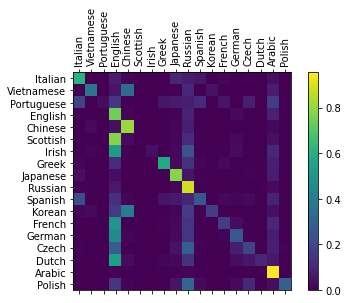

In [ ]:
# Keep track of correct guesses in a confusion matrix
n_categories = len(data)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, last_name, category_tensor, last_name_tensor = randomTrainingExample()
    output = evaluate(rnn, last_name_tensor.unsqueeze(0))
    pred, pred_idx, pred_val = category_from_output(output, dataset.targets_list)
    category_i = dataset.targets_list.index(category)
    confusion[category_i][pred_idx] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories, rotation=90)
ax.set_yticklabels([''] + categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

We can see that our network is doing very well with Arabic and Russian!



#### Let's try our network on user-defined input

In [ ]:
# Just return an output given a line
last_name = "Guasch"
output = evaluate(rnn, word_to_tensor(last_name).unsqueeze(0).to(device))
pred, pred_idx, pred_val = category_from_output(output, categories)

print("Last Name: %s \t Prediction: %s \t Certainty: %.2f %% \n"%(last_name, pred, pred_val*100))
rank_from_output(output, categories, top_n_predictions=5)

Last Name: Guasch 	 Prediction: Russian 	 Certainty: 70.90 % 

 Russian: 	 70.90%
 Arabic: 	 10.19%
 English: 	 7.87%
 Czech: 	 3.81%
 Irish: 	 2.35%


Pytorch has a nn.RNN module that allows us to implement RNNs in the same way we implement feed-forward neural networks and CNNs. Here's the [link](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) to the documentation. 

What happens if we try classification of MNIST with RNN. Will it outperform CNNs? [Can we treat pixels as time-series data? ](https://arxiv.org/pdf/2007.15161.pdf)


## Word-level text generation with RNNs


[Let's see if you can differentiate between machine generated text and human written text](http://goopt2.xyz)

We will use RNNs to build our generator network but you can also consider using LSTMs, which have a gating mechanism that allows information to continue flowing into the layers and cells of the network and have been showed to outperform vanilla RNNs for text generation.

### Downloading the data and some utility functions

In [ ]:
#download the data #example modified from https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html
!mkdir data_gen
!cd data_gen && wget https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv

filename = 'data_gen/reddit-cleanjokes.csv'

--2021-05-10 12:33:19--  https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141847 (139K) [text/plain]
Saving to: ‘reddit-cleanjokes.csv’

reddit-cleanjokes.c 100%[===================>] 138.52K  --.-KB/s    in 0.01s   

2021-05-10 12:33:19 (9.74 MB/s) - ‘reddit-cleanjokes.csv’ saved [141847/141847]



#### Function to read the lines of a file as a list of words

In [ ]:
def readFile_txt(filename): 
    """ 
    Read a txt file and return list with line entries 
    """
    lines = re.split(' |\n',open(filename, encoding="utf8").read().strip())
    return [unicode_to_ascii(line) for line in lines]

data = readFile_txt(filename)

In [ ]:
def readFile_csv(filename, header):
    """ 
    Read a csv file and return list with line entries 
    """
    dataframe = pd.read_csv(filename)
    data = dataframe[header].str.cat(sep=' ')
    data = data.split(' ')
    return data

filename, header = 'data_gen/reddit-cleanjokes.csv', 'Joke'
data = readFile_csv(filename, header)
print((data))
print(len(data))

['What', 'did', 'the', 'bartender', 'say', 'to', 'the', 'jumper', 'cables?', 'You', 'better', 'not', 'try', 'to', 'start', 'anything.', "Don't", 'you', 'hate', 'jokes', 'about', 'German', 'sausage?', "They're", 'the', 'wurst!', 'Two', 'artists', 'had', 'an', 'art', 'contest...', 'It', 'ended', 'in', 'a', 'draw', 'Why', 'did', 'the', 'chicken', 'cross', 'the', 'playground?', 'To', 'get', 'to', 'the', 'other', 'slide.', 'What', 'gun', 'do', 'you', 'use', 'to', 'hunt', 'a', 'moose?', 'A', 'moosecut!', 'If', 'life', 'gives', 'you', 'melons,', 'you', 'might', 'have', 'dyslexia.', 'Broken', 'pencils...', '...are', 'pointless.', 'What', 'did', 'one', 'snowman', 'say', 'to', 'the', 'other', 'snowman?', "'Do", 'you', 'smell', "carrots?'", 'How', 'many', 'hipsters', 'does', 'it', 'take', 'to', 'change', 'a', 'lightbulb?', "It's", 'a', 'really', 'obscure', 'number.', "You've", 'probably', 'never', 'heard', 'of', 'it.', 'Where', 'do', 'sick', 'boats', 'go?', 'The', 'dock!', 'I', 'like', 'my', 'sla

PyTorch has a library called torchtext that has functions for data processing for natural language. Here's a [link](https://pytorch.org/text/stable/index.html) to the documentation.

#### Data inspection and some more utility functions

We use a counter from the collections module to create a dictionary where the words are stored as the keys and their counts are the values. You can read more about collections [here](https://docs.python.org/3/library/collections.html).

In [ ]:
# count the number of unique words in the text
word_counts = Counter(data)
uniq_words = sorted(word_counts, key=word_counts.get, reverse=True)
print(uniq_words)
print(len(word_counts))

['the', 'a', 'What', 'you', 'to', 'do', 'I', 'of', 'did', 'Why', 'in', 'and', 'was', 'A', 'call', 'it', 'is', 'with', 'his', 'Because', 'say', 'he', 'get', 'on', 'when', 'my', 'How', 'for', 'an', 'does', 'The', 'about', 'have', 'that', 'one', 'He', 'are', 'at', 'who', "What's", 'hear', 'from', 'into', 'out', 'be', 'this', 'they', 'had', 'like', "don't", 'your', 'Did', 'go', 'can', 'but', 'joke', "I'm", 'It', 'me', 'no', 'My', 'other', 'so', 'make', 'You', 'all', 'up', 'favorite', 'know', 'their', 'just', 'got', 'what', 'not', 'They', 'take', 'cross', 'two', 'many', 'Where', 'said', 'man', 'people', 'always', 'To', 'it.', "it's", 'fish', 'between', 'her', 'if', 'by', "couldn't", 'Two', 'little', "can't", 'too', 'has', 'kind', "It's", 'cow', '.', 'would', 'only', "didn't", 'think', 'walks', 'chicken', 'will', 'heard', 'there', 'much', 'were', 'says', 'made', 'If', 'told', 'went', 'So', 'best', 'really', 'difference', 'says,', 'because', '-', 'wanted', 'time', 'When', 'never', 'she', 'why

In [ ]:
# map the unique words to indices and the indices to words
word_to_index = {word: index for index, word in enumerate(uniq_words)}
index_to_word = {index: word for index, word in enumerate(uniq_words)}

words_indexes = [word_to_index[word] for word in data]
print(words_indexes)

[2, 8, 0, 248, 20, 4, 0, 1905, 1906, 64, 534, 73, 535, 4, 1907, 1908, 225, 3, 226, 227, 31, 249, 1909, 314, 0, 1910, 93, 704, 47, 28, 705, 1077, 57, 424, 10, 1, 347, 9, 8, 0, 107, 76, 0, 706, 84, 22, 4, 0, 61, 1911, 2, 1078, 5, 3, 133, 4, 1912, 1, 1913, 13, 1914, 115, 275, 1079, 3, 1915, 3, 348, 32, 1916, 1917, 1918, 1080, 1919, 2, 8, 34, 707, 20, 4, 0, 61, 708, 1920, 3, 425, 1921, 26, 78, 1081, 29, 15, 75, 4, 187, 1, 276, 99, 1, 120, 1082, 1922, 1083, 709, 128, 109, 7, 85, 79, 5, 349, 1084, 710, 30, 1923, 6, 48, 25, 1085, 48, 6, 48, 25, 1924, 1086, 60, 426, 116, 58, 129, 12, 1087, 58, 123, 6, 164, 1925, 4, 44, 1, 1926, 6, 174, 1088, 1927, 6, 53, 1928, 427, 711, 1929, 350, 38, 73, 351, 10, 1089, 712, 202, 34, 1930, 2, 8, 0, 1090, 7, 1, 1931, 713, 20, 24, 18, 713, 714, 715, 315, 165, 0, 1932, 1933, 1934, 2, 1091, 7, 1935, 1936, 3, 1937, 13, 1938, 1939, 1940, 1941, 1942, 7, 25, 1943, 1944, 1945, 2, 8, 0, 316, 133, 4, 1092, 139, 145, 1946, 13, 1947, 1948, 2, 8, 0, 316, 133, 4, 22, 43, 0, 


Our inputs will be the words of a chosen sequence length, and the outputs will be the next word.
We want to predict the next word from the current sequence of words, so we will create sequences, which are groups of consecutive words. 

For example, consider the sentence: **What did the bartender say to the jumper cables?**. For a chosen sequence length of 4:
- input sequence: ['What', 'did', 'the', 'bartender'] 
- target sequence: ['did', 'the', 'bartender', 'say'] 

The output sequence is always one time step ahead of the input.

In [ ]:
sequence_length= 4
index = 0
tensor_in = torch.tensor(words_indexes[index:index+sequence_length])
tensor_out =torch.tensor(words_indexes[index+1:index+sequence_length+1])

print(tensor_in)
print(tensor_out)

tensor([  2,   8,   0, 248])
tensor([  8,   0, 248,  20])


## Exercise 4: Create a custom TensorDataset that allows us to perform the following:
- take as inputs a list of all words in our text
- Generate a dictionary of all unique words and their counts, sorted in descending order
- Return a sample of input and output data

In [ ]:
class WordsTensorDataset(TensorDataset):
    def __init__(self, data_list, sequence_length=4):
        """
        Args:
            data_list (dictionary): A list of all the words in the file
            sequence_length: the number of words in each input sample, and output sample
        """
        self.sequence_length = sequence_length
        self.data_list = data_list
        self.unique_words = self.get_unique_words()

        # create a dictionary of mappings of words to indices
        # create a dictionary of mappings of indices to words     

        # return a list of the data with the words represented with their indices

    def get_unique_words(self):
        # return a list of the unique words called word_counts
        return sorted(word_counts, key=word_counts.get, reverse=True)  

    def __len__(self):
        return len(self.words_idxs) - self.sequence_length

    def __getitem__(self, idx):

        # get a sample input sequence
        # get a sample output sequence

        return sample_input, sample_output

In [ ]:
words_dataset = WordsTensorDataset(data, sequence_length=4)
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)

next(iter(words_dataloader))

[tensor([[   2,    8,    0,  248],
         [   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905]]), tensor([[   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905],
         [   4,    0, 1905, 1906]])]

## Implement a Text "Generator" - RNN

We will use the pytorch built-in Embedding and RNN module for this exercise. The [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) enables us to store word embeddings and use it as a look-up table, and the [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) module allows us to create an RNN layer. We can also stack multiple layers by specifying more than one layer. We will now implement a text generator with the following layers:
- nn.Embedding: applied instead of one-hot encoding to represent data. It is more efficient as it compresses the dimension of the words and encodes the semantics of the words (i.e.  how similar each word is used within our context).
- nn.RNN: the recurrent neural network layer. We can stack multiple LSTM layers and also add dropout.
- nn.Linear: a fully connected layers that allows us to map the hidden neurons to the output


In [ ]:
class RNN_GEN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(RNN_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        
        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_unique_words)


    def init_hidden_state(self,batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)


    def forward(self,x):
        # initialise hidden state
        # store the word embeddings
        # get the output and next hidden state
        # get the logits
        return logits, hidden


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

Define the train and evaluate functions

In [ ]:
def train_rnn_gen(model, optimizer, criterion, dataloader):
    
    #set model to train mode
    #initialise the loss 
    
    #loop over dataset 
        
    # send data to device
    # reset the gradients
    # get output and hidden state
    # compute the loss
    
    #backpropagate 
    #update weights

    return train_loss/len(dataloader)
    

def predict_rnn_gen(dataset, model, text, next_words=100):
    model.eval()

    words = text.split(' ')

    for i in range(next_words):
        x = torch.tensor([[dataset.word_to_idx[word] for word in words[i:]]]).to(device)
        y_pred,hidden = rnn_gen(x)
       
        last_word_logits = y_pred[0][-1]                  
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_idx = np.random.choice(len(last_word_logits), p=p)

        words.append(dataset.idx_to_word[word_idx])

    return ' '.join(words)

###Hyperparameters, model initialisation and the training loop

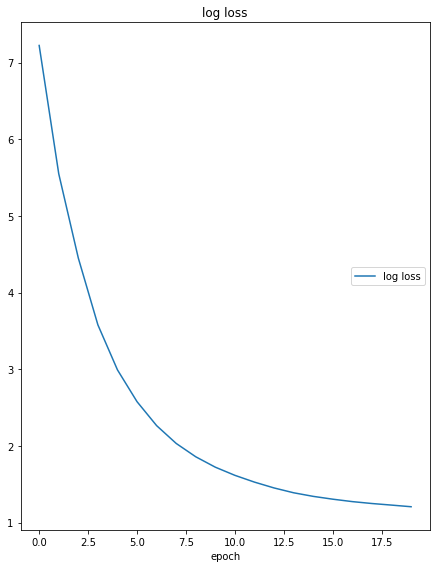

log loss
	log loss         	 (min:    1.207, max:    7.224, cur:    1.207)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 128
n_hidden = 128                         
n_layers = 1
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 256
sequence_length = 4

lr = 5e-3
momentum = 0.5
n_epochs = 20

rnn_gen = RNN_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(rnn_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)   

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_rnn_gen(rnn_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

#### Let's try predicting with our network

In [ ]:
print(predict_rnn_gen(words_dataset, rnn_gen, text='Knock knock. Whos there?', next_words=100))

Knock knock. Whos there? Well, not your parents, take a long joke? Joke joke jooooke! What happened to the runny nose... it tripped and fell. Now it's all boogered up. Four years ago, I asked to a shredded cheese? hand sanitizer!!! Wanna hear a pterodactyl go to me eventually. What did the seaweed... Where did the seaweed... Where did the Texan barber recommend when asked? He couldn't think of anything, and said "I'll mullet over" [OC] How does Gandhi measure passive resistance? In oooooohms. Why is a bacteria's report? but fun when you're Russian. Any more? :) Wanna hear a one says: "I'll man


##Exercise 5: Implement a Text "Generator" - LSTM


Simple RNNs have trouble learning. For example, if we try to predict the last word in the sentence: **There are so many clouds in the _sky_.** This is easy for a simple RNN to predict as the necessary context word _clouds_ appeared just two words ago. 

However, look at the following example: **I grew up in France... I speak fluent _French_**. The distance between the contextual clue word _France_ and the predicted word _French_ could have been arbitrarily long in this text. Furthermore, the vanishing gradient and exploding gradient effects during backpropagation affect the performance of RNN. Given a very long sequence, information at the start of the sequence might have almost no impact at the end of the sequence.

In [ ]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(LSTM_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_unique_words)


    def init_states_h_c(self, batch_size):

          #initialise the hidden and cell states
          #return hidden and cell states


    def forward(self, x):
        
        # initialise hidden state
        # store the word embeddings
        # get the output and next hidden and cell states
        # get the logits

        return logits, (state_h, state_c)


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

### The train and predict functions

In [ ]:
def train_lstm_gen(model, optimizer, criterion, dataloader):
    
    #set model to train mode
    #initialise the loss 
    
    #loop over dataset 
        
    # send data to device
    # reset the gradients
    # get output and hidden state
    # compute the loss
    
    #backpropagate 
    #update weights

    return train_loss/len(dataloader)


def predict_lstm_gen(dataset, model, text, next_words=10):
    
    model.eval()

    words = text.split(' ')

    for i in range(next_words):
        x = torch.tensor([[dataset.word_to_idx[word] for word in words[i:]]]).to(device)
        y_pred, (state_h, state_c) = lstm_gen(x)
       
        last_word_logits = y_pred[0][-1]
                  
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_idx = np.random.choice(len(last_word_logits), p=p)

        words.append(dataset.idx_to_word[word_idx])

    return ' '.join(words)

### Hyperparameters, model initialisation and training loop

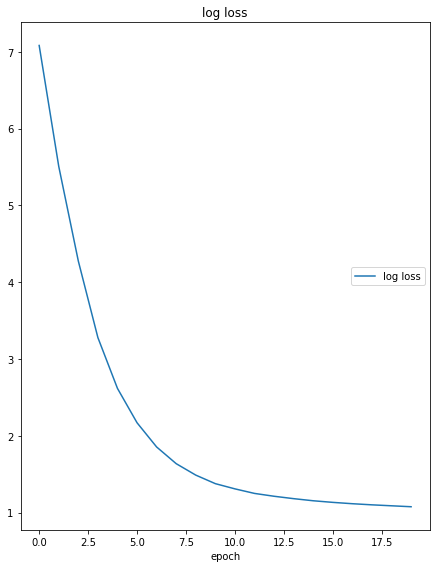

log loss
	log loss         	 (min:    1.076, max:    7.084, cur:    1.076)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 128
n_hidden = 128                         
n_layers = 1
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 128
sequence_length = 4

lr = 5e-3
momentum = 0.5
n_epochs = 20

lstm_gen = LSTM_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_lstm_gen(lstm_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

Let's try to predict the next 

In [ ]:
print(predict_lstm_gen(words_dataset, lstm_gen, text='Knock knock. Whos there?', next_words=100))

Knock knock. Whos there? Well, not your parents, because your parents never knock! What do you call a dog with no legs? Ground beef. There once was a girl from Nantucket... Who carried her ice in a bucket. She walked down a hill. She had a great spill. And when she got up, she said, "I'm going to watch my step next time!" Why are bears so hairy ? They don't have salons in the jungle ! How many tickles does it take to make an octopus laugh? Ten tickles What did one earthquake say to the other? Hey, it's not my fault. I


We can see that the LSTM generates more coherent text, and jokes that are more funny too!

# Recent Advances

The long-term memory in LSTM is [a specific instance](https://arxiv.org/pdf/1601.06733.pdf) of a more generic concept called _Attention_. The concept of Attention was introduced to solve one problem - when doing _Neural Machine Translation_ , the next word in the output sentence (in the output language) is not necessary related to the last (or second-to-last) word in the input sentence (in the input language). Since simple RNNs can only capture adjacency relationships, various styles of attention were tried to teach the model to look at a specific part of the input sentence in order to predict the next output word. [Many of these attention approaches](https://arxiv.org/abs/1409.0473) were successful and today far outperform LSTMs on the above tasks. 

![](images/self-attention.png)

One extremely successful kind of attention is _self attention_. Here, instead of mapping relationships between an output sequence and an input sequence, we map relationships between the different words of the same sentence. Going down this path, it was realised that the self-attention mechanism is more than just an add-on to RNNs and it might be possible to build entire networks out of self-attention alone. In ["Attention is all you need" (Vasuvani 2017)](https://arxiv.org/pdf/1706.03762.pdf) a neural network architecture called _Transformer_ was introduced that was composed entirely of self attention layers, and had some other innovations regarding memory. 

![](images/transformer.png)

In Feb 2019, a company called OpenAI introduced a variation of the transformer called GPT2 and [refused to release](https://slate.com/technology/2019/02/openai-gpt2-text-generating-algorithm-ai-dangerous.html) it _claiming it might destroy human society_ . This was a text generation model that could generate entire (_fake_) news articles from a one/few word prompt - think of it as autocomplete on steroids. They did eventually release it and is now available to try online: https://talktotransformer.com

### In summary, we have learnt how to:
- Develop utility functions for handling text data as time series data
- Create custom TensorDatasets
- Classify names with character-level RNN with two layers from scratch
- Use PyTorch modules to implement a word-level text generator using RNNs
- Implement word-level text generation with LSTMs which outperform vanilla RNNs
